# Сборный проект 2

**Заказчик** этого исследования — компания «Работа с заботой».<br><br>
**Цель проекта:**
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. 

**Описание данных:**<br>
для первой модели данные содержат информацию: характеристики сотрудника и уровень удовлетворенности работой.
Данные содержатся в 3 csv-файлах: train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate.<br>
Для второй модели присутствует также признак - увольнение сотрудника.
Данные содержатся в 3 csv-файлах: train_quit, test_features, test_target_quit.<br>

**План работ:**<br>
- загрузить данные
- предобработать данные: преобразовать типы, заполнить пропуски, обработать дубликаты.
- исследовать общую информацию.
- объединить данные и визуализировать информацию.
- провести корреляционный анализ.
- выбрать лучшую модель предсказания уровня удовлетворенности сотрудника.
- добавить предсказанной значение уровня удовлетворенности сотрудника в данные второй задачи.
- выбрать лучшую модель, предсказывающую, уволится ли сотрудник.

## Предсказание уровня удовлетворённости сотрудника

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
import phik

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import make_scorer, roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from warnings import simplefilter

import shap

from scipy import stats as st

In [3]:
#!pip uninstall scikit-learn
!pip install scikit-learn==0.24.1

In [4]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [5]:
import sklearn
print(sklearn.__version__)

0.24.1


In [6]:
pd.set_option('chained_assignment', None)

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Загрузка данных

In [7]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except FileNotFoundError:
    print('Файл не найден. Необходимо проверить путь к файлу')
except Exception:
    print('Файл не загрузился')

In [8]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [10]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [11]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [12]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [13]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Загрузили данные из трех источников.<br>
В таблице **train_job_satisfaction_rate** 4000 строк, есть несколько пропусков в столбцах dept и level. Типы данных соответствуют. Таблица содержит тренировочную выборку - характеристики сотрудников компании. <br>
В таблице **test_features** 2000 строк, есть несколько пропусков в столбцах dept и level, типы данных соответствуют. Она хранит входные признаки тестовой выборки.<br>
В таблице **test_target_job_satisfaction_rate** 2000 строк, пропусков нет, типы данных соответствуют. Таблица хранит целевой признак тестовой выборки.<br>
<br>
Данные в таблицах соответсвуют описанию.

### Предобработка данных

**Исследование таблицы train_job_satisfaction_rate**

In [14]:
#Проверка на пропуски в данных
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [15]:
# проверка на явные дубликаты
train_job_satisfaction_rate.duplicated().sum()

0

Есть 6 пропусков в столбце dept, 4 пропуска в столбце level. Явных дубликатов нет.<br>
Проверим неявные дубликаты.

In [16]:
train_job_satisfaction_rate['id'].duplicated().sum()

0

In [17]:
train_job_satisfaction_rate['dept'].value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

In [18]:
train_job_satisfaction_rate['level'].value_counts()

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

In [19]:
train_job_satisfaction_rate['workload'].value_counts()

medium    2066
low       1200
high       734
Name: workload, dtype: int64

In [20]:
train_job_satisfaction_rate['last_year_promo'].value_counts()

no     3880
yes     120
Name: last_year_promo, dtype: int64

In [21]:
train_job_satisfaction_rate['last_year_violations'].value_counts()

no     3441
yes     559
Name: last_year_violations, dtype: int64

Неявных дубликатов в таблице train_job_satisfaction_rate тоже не обнаружено.

**Исследование таблицы test_features**

In [22]:
#Проверка на пропуски в данных
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Есть 2 пропуска в столбце dept и 1 в столбце level.

In [23]:
# проверка на явные дубликаты
test_features.duplicated().sum()

0

Явных дубликатов нет. Проверим на неявные дубликаты.

In [24]:
test_features['id'].duplicated().sum()

0

In [25]:
test_features['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

есть одно незаполненное значение.

In [26]:
test_features['level'].value_counts()

junior    974
middle    854
sinior    171
Name: level, dtype: int64

In [27]:
test_features['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

Также есть одно незаполненное значение.

In [28]:
test_features['last_year_promo'].value_counts()

no     1937
yes      63
Name: last_year_promo, dtype: int64

In [29]:
test_features['last_year_violations'].value_counts()

no     1738
yes     262
Name: last_year_violations, dtype: int64

Нашли некоторые незаполненные значения в столбцах workload, dept.<br>
Явных и неявных дубликатов обнаружено не было. Значения переменных совпадают со значениями в тренировочной выборке.

**Исследование таблицы test_target_job_satisfaction_rate**

In [30]:
#Проверка на пропуски в данных
test_target_job_satisfaction_rate.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [31]:
# проверка на явные дубликаты
test_target_job_satisfaction_rate.duplicated().sum()

0

In [32]:
test_target_job_satisfaction_rate['id'].duplicated().sum()

0

В таблице test_target_job_satisfaction_rate нет ни пропусков, ни дубликатов.

В таблицах были обнаружены некоторые пропуски. Мы их заполним далее - в пайплайне.

### Исследовательский анализ данных

#### Анализ количественных признаков

In [33]:
#Проверка на пропуски в данных
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


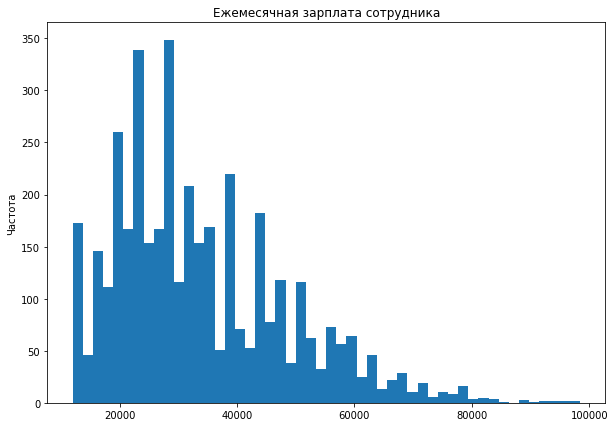

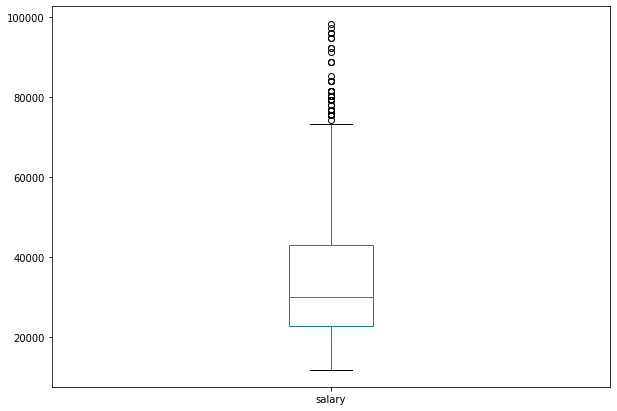

In [34]:
train_job_satisfaction_rate.plot(y='salary',title='Ежемесячная зарплата сотрудника', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
train_job_satisfaction_rate.plot(y='salary', kind='box' , figsize = (10,7), legend = False);

In [35]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Распределение признака Ежемесячная зарплата не очень похоже на нормальное. Есть некоторые всплески и скос влево.<br>
В среднем зарплата сотрудника составляет 33927.<br>
Разброс довольно большой, но в основном зарплата составляет от 22800 до 43200 кг.<br>
Есть выбросы, но сильных аномалий нет, зарплата - в пределах нормы.

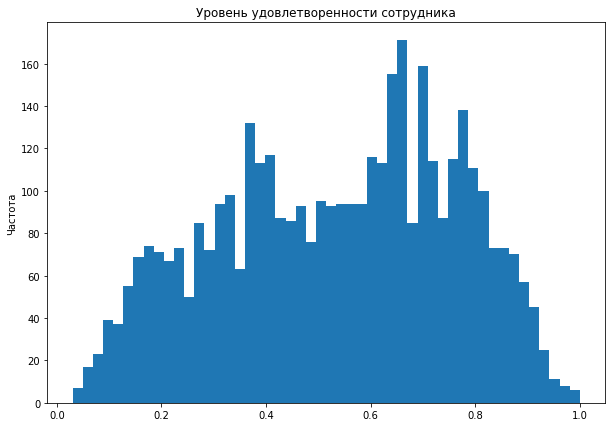

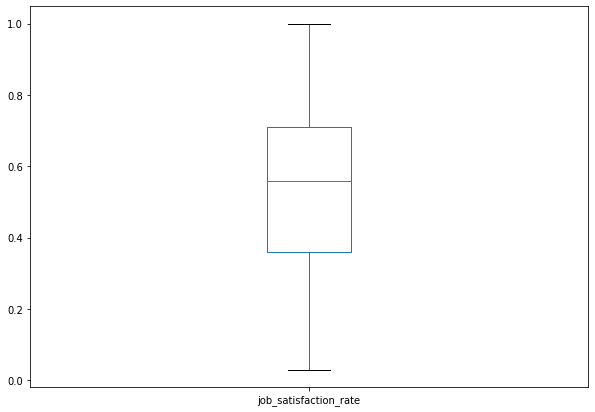

In [36]:
train_job_satisfaction_rate.plot(y='job_satisfaction_rate',title='Уровень удовлетворенности сотрудника', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
train_job_satisfaction_rate.plot(y='job_satisfaction_rate', kind='box' , figsize = (10,7), legend = False);

Выбросов нет, распределение немного похоже на нормальное.<br>
Среднее значение уровня удовлетворенности: 0.53. Колеблется в основном от 0.36 до 0.71.

#### Анализ категориальных переменных

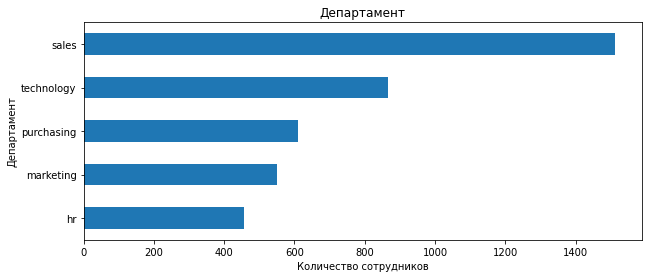

In [37]:
train_job_satisfaction_rate.pivot_table(index = 'dept', aggfunc = 'count')['id'].sort_values().plot(y='dept',title='Департамент', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Департамент");
plt.xlabel("Количество сотрудников");

Есть 5 департаментов. Больше всего сотрудников в sales, меньше всего в hr.

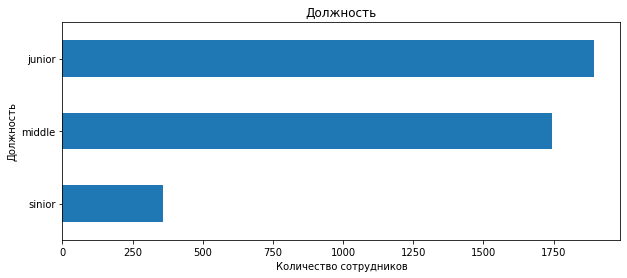

In [38]:
train_job_satisfaction_rate.pivot_table(index = 'level', aggfunc = 'count')['id'].sort_values().plot(y='level',title='Должность', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Должность");
plt.xlabel("Количество сотрудников");

Примерно равное количество сотрудников на уровнях junior, middle. и значительно меньшее количество сотрудников на позиции sinior.

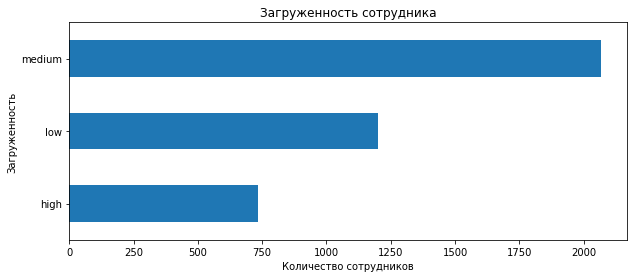

In [39]:
train_job_satisfaction_rate.pivot_table(index = 'workload', aggfunc = 'count')['id'].sort_values().plot(y='workload',title='Загруженность сотрудника', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Загруженность");
plt.xlabel("Количество сотрудников");

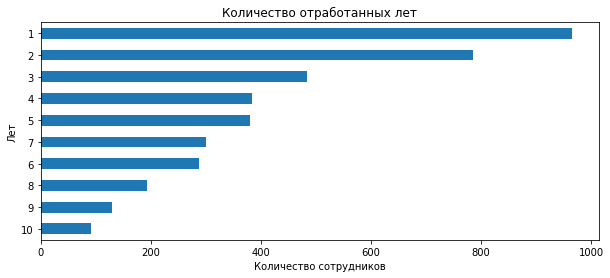

In [40]:
train_job_satisfaction_rate.pivot_table(index = 'employment_years', aggfunc = 'count')['id'].sort_values().plot(y='employment_years',title='Количество отработанных лет', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Лет");
plt.xlabel("Количество сотрудников");

Больше всего в компании новичков.

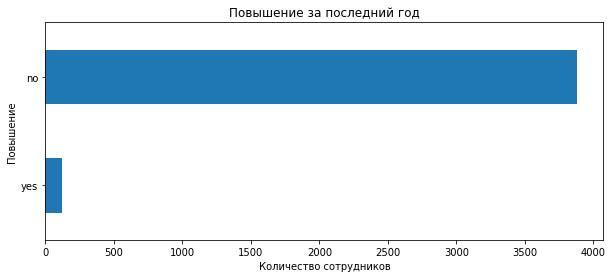

In [41]:
train_job_satisfaction_rate.pivot_table(index = 'last_year_promo', aggfunc = 'count')['id'].sort_values().plot(y='last_year_promo',title='Повышение за последний год', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Повышение");
plt.xlabel("Количество сотрудников");

У совсем малой доли сотрудников было повышение зарплаты за последний год.

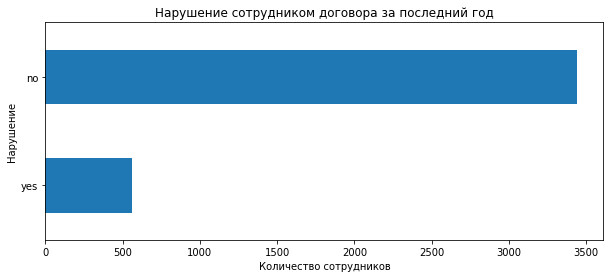

In [42]:
train_job_satisfaction_rate.pivot_table(index = 'last_year_violations', aggfunc = 'count')['id'].sort_values().plot(y='last_year_violations',title='Нарушение сотрудником договора за последний год', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Нарушение");
plt.xlabel("Количество сотрудников");

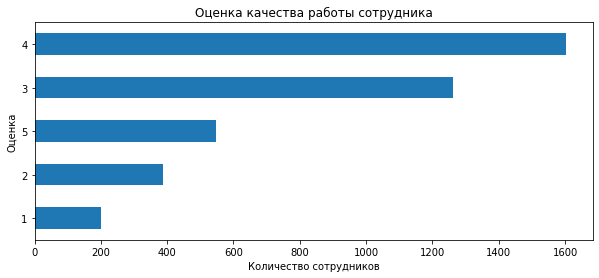

In [43]:
train_job_satisfaction_rate.pivot_table(index = 'supervisor_evaluation', aggfunc = 'count')['id'].sort_values().plot(y='supervisor_evaluation',title='Оценка качества работы сотрудника', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Оценка");
plt.xlabel("Количество сотрудников");

Большинство сотрудников работают хорошо. Оценка руководства по шкале от 1 до 5.

**Проанализировали признаки**:
- целевой признак Уровень удовлетворенности сотрудника: средняя удовлетворенность оценивается в 0.53, выбросов нет.
- количественные признаки: аномальных значений не обнаружено.
- категориальные признаки: проанализировали и просмотрели возможные значения.<br>

Необходимо масштабировать количественные признаки и закодировать категориальные для использования их в модели. А также проследить, нет ли взаимосвязи между признаками и наблюдается ли линейная взаимосвязь с целевым признаком.

In [44]:
train_job_satisfaction_rate.phik_matrix(interval_cols = ['id', 'salary', 'job_satisfaction_rate'])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,1.000000,0.060172,0.000000,0.059274,0.047183,0.024593,0.000000,0.033387,0.000000,0.000000
dept,0.060172,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.059274,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.047183,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.024593,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.033387,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.000000,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.000000,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


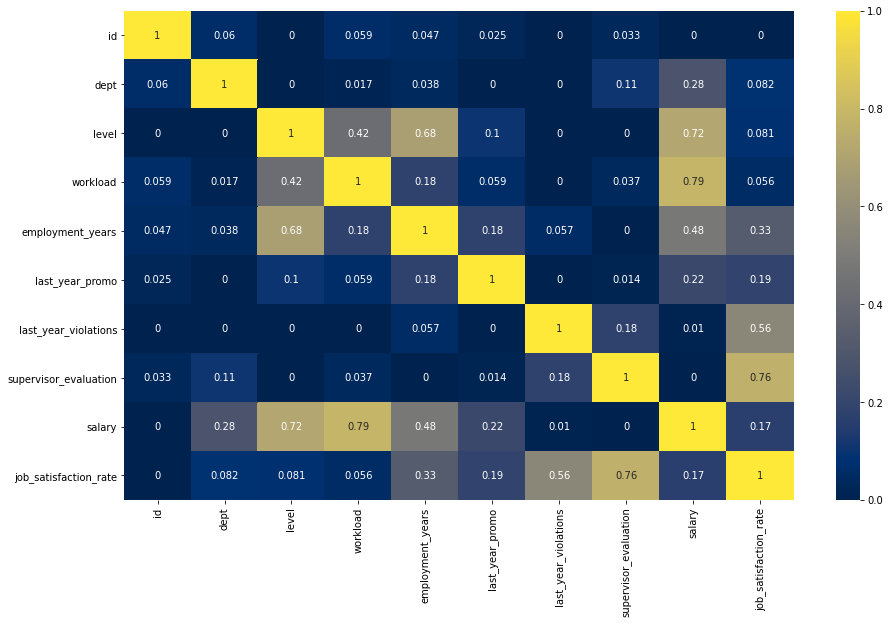

In [45]:
fig, ax = plt.subplots(figsize=(15,9));
sns.heatmap(train_job_satisfaction_rate.phik_matrix(interval_cols = ['id', 'salary', 'job_satisfaction_rate']), annot=True, cmap='cividis', ax = ax);

Видим связь целевого признака Уровень удовлетворенности сотрудника и его оценкой начальства.<br>
Наблюдаются связи между признаками: зарплаты и должности/загрузки сотрудника; уровня сотрудника и количества отработанных лет.<br>
Мультиколлинеарности не обнаружено.

### Подготовка данных

In [46]:
RANDOM_STATE = 42

In [47]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

In [48]:
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
test = test_features.merge(test_target_job_satisfaction_rate, on = 'id')
X_test = test.drop(['job_satisfaction_rate'], axis=1)
y_test = test['job_satisfaction_rate']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 8), (2000, 8), (4000,), (2000,))

In [49]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation']

In [50]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))#drop='first',
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [51]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

In [52]:
# создаём функцию для расчёта точности предсказаний каждого класса
def SMAPE(y_true, y_pred):
    error = np.abs(y_true-y_pred)
    scale = (np.abs(y_pred)+np.abs(y_true))/2
    metric = np.mean(error/scale)*100
    return metric

In [53]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': range(2,20),
        'models__min_samples_split': range(2,20),
        'models__max_depth': range(2,20),
        #'models__max_features': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(
                   
                  )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    
]
scorer = make_scorer(SMAPE, greater_is_better = False)
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring= scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {SMAPE(y_test, pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

### Промежуточные выводы

К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder, OrdinalEncoder).<br>
Применяли модели:<br>
    - DecisionTreeRegressor с параметрами max_depth, min_samples_leaf, min_samples_split<br>
    - LinearRegression<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали собственной метрикой SMAPE («симметричное среднее абсолютное процентное отклонение»)<br>

Наилучшей оказалась модель **дерево решений** с параметрами:<br>
max_depth=18, min_samples_leaf=6, min_samples_split=11<br>
На тестовой выборке она показывает результат 13.86

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [54]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except FileNotFoundError:
    print('Файл не найден. Необходимо проверить путь к файлу')
except Exception:
    print('Файл не загрузился')

In [55]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [56]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [57]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [58]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Загрузили данные из двух источников.<br>
В таблице **train_quit** 4000 строк, пропусков нет. Типы данных соответствуют. Таблица содержит тренировочную выборку - характеристики сотрудников компании. <br>
В таблице **test_target_quit** 2000 строк, пропусков нет, типы данных соответствуют. Таблица хранит целевой признак тестовой выборки.<br>
<br>
Данные в таблицах соответсвуют описанию.<br>
Тестовой выборкой является уже загруженная test_features.

### Предобработка данных

In [59]:
#Проверка на пропуски в данных
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [60]:
# проверка на явные дубликаты
train_quit.duplicated().sum()

0

In [61]:
train_quit['id'].duplicated().sum()

0

In [62]:
train_quit['dept'].value_counts()

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

In [63]:
train_quit['level'].value_counts()

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

In [64]:
train_quit['workload'].value_counts()

medium    2118
low       1208
high       674
Name: workload, dtype: int64

In [65]:
train_quit['last_year_promo'].value_counts()

no     3887
yes     113
Name: last_year_promo, dtype: int64

In [66]:
train_quit['last_year_violations'].value_counts()

no     3455
yes     545
Name: last_year_violations, dtype: int64

In [67]:
train_quit['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

In [68]:
test_target_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

В новых загруженных данных структура и значения сходны с данными, используемыми в первой задаче. Пропусков нет и добавился столбец quit. Наблюдается дисбаланс классов.

### Исследовательский анализ данных

#### Анализ данных

In [69]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [70]:
train_job_satisfaction_rate.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


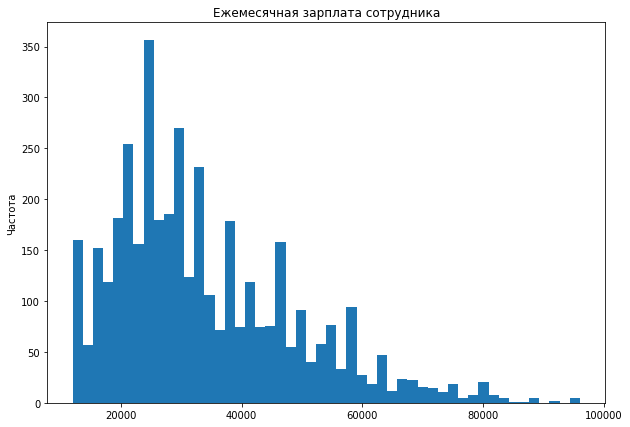

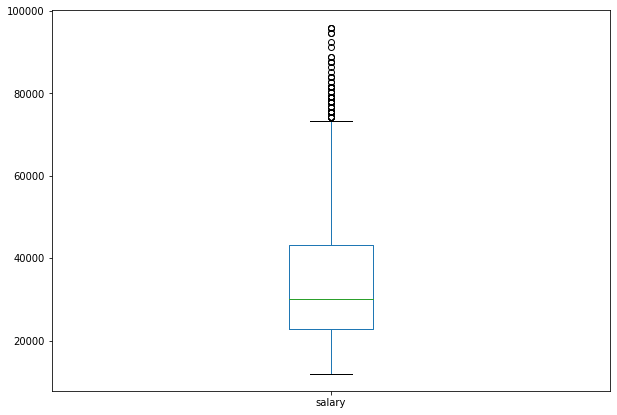

In [71]:
train_quit.plot(y='salary',title='Ежемесячная зарплата сотрудника', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
train_quit.plot(y='salary', kind='box' , figsize = (10,7), legend = False);

В целом описательные статистики тренировочной выборки похожи на train_job_satisfaction_rate. Немного отличается по значениям salary, но по графику распределения похожи.

#### Характеристики уволившегося сотрудника

In [72]:
train_quit_yes = train_quit.query('quit == "yes"')

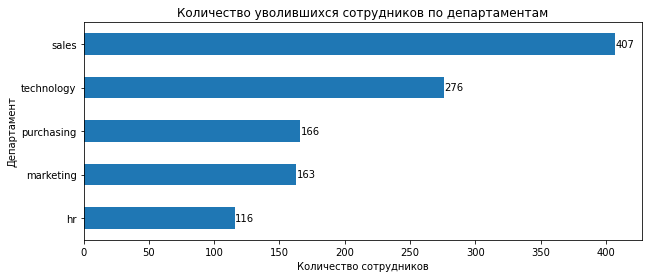

In [73]:
df_dept = train_quit_yes.pivot_table(index = 'dept', aggfunc = 'count')['id'].sort_values()
df_dept.plot(y='dept',title='Количество уволившихся сотрудников по департаментам', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Департамент");
plt.xlabel("Количество сотрудников");
for i, v in enumerate(df_dept):
    plt.text(v + 0.2, i, str(v), color='black', va='center')

In [74]:
df_dept_part = train_quit.pivot_table(index = ['dept'], columns = 'quit', aggfunc = 'count')['id']
df_dept_part['part'] = round(df_dept_part['yes']/(df_dept_part['yes'] + df_dept_part['no']),2)
display(df_dept_part)

quit,no,yes,part
dept,,,
hr,348,116,0.25
marketing,419,163,0.28
purchasing,422,166,0.28
sales,1031,407,0.28
technology,652,276,0.30


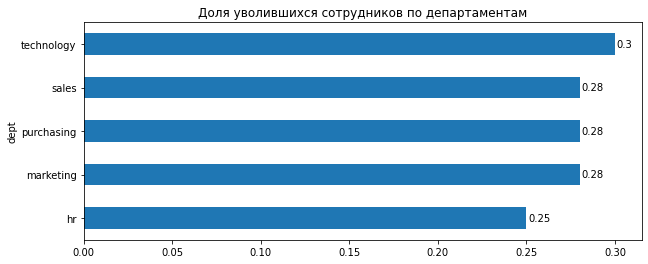

In [75]:
df_dept_part.plot(y=['part'],title='Доля уволившихся сотрудников по департаментам', kind='barh' , figsize = (10,4), legend = False)
for i, v in enumerate(df_dept_part['part']):
    plt.text(v+0.001 , i, v, color='black', va='center')

Больше всего увольняется сотрудников из отдела sales, но если посмотреть на долю уволившихся сотрудников, то больше всего она в technology: 0.3.<br>
Меньше всего увольнений в hr, доля составляет 0.25.

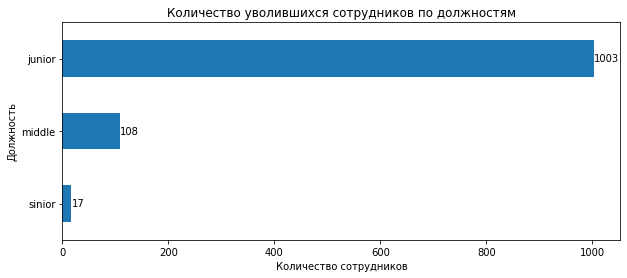

In [76]:
df_level = train_quit_yes.pivot_table(index = 'level', aggfunc = 'count')['id'].sort_values()
df_level.plot(y='level',title='Количество уволившихся сотрудников по должностям', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Должность");
plt.xlabel("Количество сотрудников");
for i, v in enumerate(df_level):
    plt.text(v + 0.2, i, str(v), color='black', va='center')

In [77]:
df_level_part = train_quit.pivot_table(index = ['level'], columns = 'quit', aggfunc = 'count')['id']
df_level_part['part'] = round(df_level_part['yes']/(df_level_part['yes'] + df_level_part['no']),2)
df_level_part = df_level_part.sort_values(by='part')
display(df_level_part)

quit,no,yes,part
level,,,
sinior,340,17,0.05
middle,1586,108,0.06
junior,946,1003,0.51


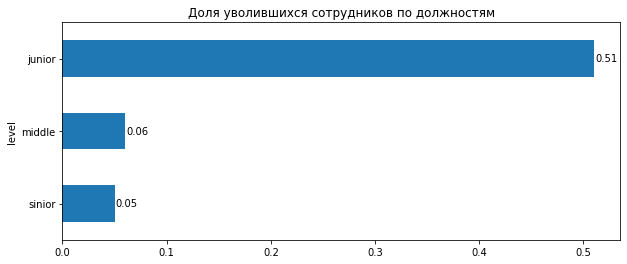

In [78]:
df_level_part.plot(y=['part'],title='Доля уволившихся сотрудников по должностям', kind='barh' , figsize = (10,4), legend = False)
for i, v in enumerate(df_level_part['part']):
    plt.text(v+0.001 , i, v, color='black', va='center')

Больше всего сотрудников увольняется с уровнем junior - половина сотрудников уровня junior увольняется. Доля увольняющихся middle и sinior гораздо меньше и сотсавляет 0.06/0.05 соответственно.

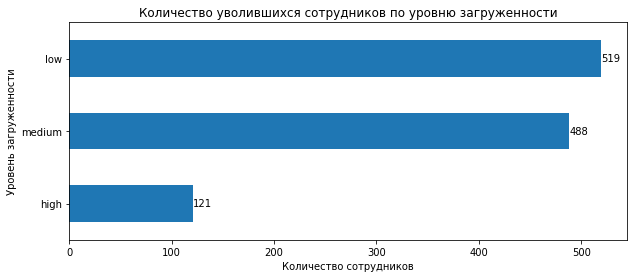

In [79]:
df_workload = train_quit_yes.pivot_table(index = 'workload', aggfunc = 'count')['id'].sort_values()
df_workload.plot(y='workload',title='Количество уволившихся сотрудников по уровню загруженности', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Уровень загруженности");
plt.xlabel("Количество сотрудников");
for i, v in enumerate(df_workload):
    plt.text(v + 0.2, i, str(v), color='black', va='center')

In [80]:
df_workload_part = train_quit.pivot_table(index = ['workload'], columns = 'quit', aggfunc = 'count')['id']
df_workload_part['part'] = round(df_workload_part['yes']/(df_workload_part['yes'] + df_workload_part['no']),2)
df_workload_part = df_workload_part.sort_values(by='part')
display(df_workload_part)

quit,no,yes,part
workload,,,
high,553,121,0.18
medium,1630,488,0.23
low,689,519,0.43


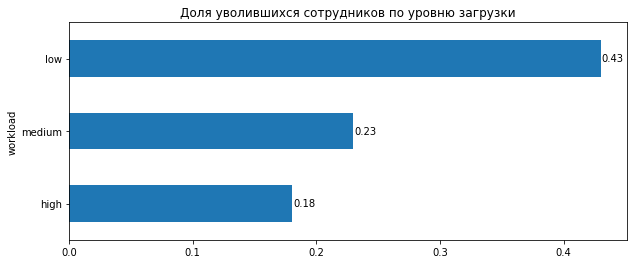

In [81]:
df_workload_part.plot(y=['part'],title='Доля уволившихся сотрудников по уровню загрузки', kind='barh' , figsize = (10,4), legend = False)
for i, v in enumerate(df_workload_part['part']):
    plt.text(v+0.001 , i, v, color='black', va='center')

Интересно, что больше всего сотрудников увольняется с уровнем загрузки low, а сильно загруженные сотрудники остаются. Доля уволившихся сотрудников по уровням low, medium, high составляет 0.43, 0.23, 0.18 соответственно.

In [82]:
train_quit_yes['salary'].median()

22800.0

In [83]:
train_quit['salary'].median()

30000.0

In [84]:
train_quit_yes['salary'].mean()

23885.106382978724

In [85]:
train_quit['salary'].mean()

33805.8

уровень зарплаты уволившихся и оставшихся сотрудников существенно различается: у уволившихся сотрудников средняя зарплата гораздо меньше.

#### Зависимость увольнения от уровня удовлетворенности сотрудника

In [86]:
test_plot = test_target_quit.merge(test_target_job_satisfaction_rate, on = 'id', how = 'inner')

In [87]:
test_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   quit                   2000 non-null   object 
 2   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ KB


Объединили две тестовые выборки с целевым признаком, чтобы оценить, как влияет уровень удовлетворенности на увольнение.

In [88]:
test_plot_yes = test_plot.query('quit=="yes"')
test_plot_no = test_plot.query('quit=="no"')

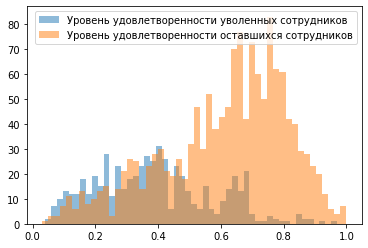

In [89]:
plt.hist(test_plot_yes['job_satisfaction_rate'], alpha = 0.5, bins=50,  label = 'Уровень удовлетворенности уволенных сотрудников')
plt.hist(test_plot_no['job_satisfaction_rate'], alpha = 0.5, bins=50,  label = 'Уровень удовлетворенности оставшихся сотрудников');
plt.legend(loc='upper right');

In [90]:
test_plot_yes.describe()

,id,job_satisfaction_rate
count,564.000000,564.000000
mean,563164.792553,0.387713
std,251523.775926,0.185784
min,103221.000000,0.040000
25%,358969.500000,0.240000
50%,554657.000000,0.370000
75%,781640.250000,0.492500
max,999029.000000,0.970000


In [91]:
test_plot_no.describe()

,id,job_satisfaction_rate
count,1436.000000,1436.000000
mean,548680.699164,0.612040
std,254730.637881,0.199367
min,100298.000000,0.030000
25%,327477.750000,0.500000
50%,546372.000000,0.660000
75%,761578.500000,0.760000
max,998900.000000,1.000000


Среднее значение уровня удовлетворенности у оставшихся сотрудников значительно выше, чем у уволившихся. Это видно и по распределению уровня у оставшихся сотрудников. Оно скошено вправо.

Проверим гипотезу:<br>
Нулевая гипотеза: среднее значение уровня удовлетворенности работой ушедших сотрудников равно среднему значению уровня удовлетворенности оставшихся сотрудников<br>
Альтернативная гипотеза: среднее значение уровня удовлетворенности работой оставшихся сотрудников больше среднего уровня удовлетворенности работой ушедших сотрудников<br>
У нас две независимые выборки, в связи с этим используем *ttest_ind*

In [92]:
alpha = 0.01
results = st.ttest_ind(test_plot_no['job_satisfaction_rate'], test_plot_yes['job_satisfaction_rate'], alternative = 'greater')
print('p-значение: ',results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  6.1556103325868406e-105
Отвергаем нулевую гипотезу


p-value достаточно мало. <br>
Нулевая гипотеза о том, что среднее значение уровня удовлетворенности работой ушедших и оставшихся сотрудников равны, отвергнута.<br>
Есть основания утверждать, что среднее значение уровня удовлетворенности работой оставшихся сотрудников больше.

#### Добавление нового входного признака

In [93]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [94]:
train_quit= train_quit.set_index('id')


In [95]:
test_target_quit= test_target_quit.set_index('id')

Добавим в тренировочную выборку результат предсказания уровня удовлетворенности сотрудника, полученный с помощью лучше модели.

In [96]:
train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(train_quit.drop(['quit'], axis = 1))

Также добавим смоделированный признак уровень удовлетворенности сотрудника в тестовую выборку.

In [97]:
test_features['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(test_features)

In [98]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.868571
686555,hr,junior,medium,1,no,no,4,30000,0.676667
467458,sales,middle,low,5,no,no,4,19200,0.680000
418655,sales,middle,low,6,no,no,4,19200,0.686250
789145,hr,middle,medium,5,no,no,5,40800,0.786667


#### Подготовка данных

In [99]:
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']
test = test_features.merge(test_target_quit, on = 'id')
X_test = test.drop(['quit'], axis=1)
y_test = test['quit']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 9), (2000, 9), (4000,), (2000,))

In [100]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate']

In [101]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))#drop='first',
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [102]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [103]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [104]:
print(label_encoder.classes_)

['no' 'yes']


Для подготовки данных написали пайплайн.<br>
Также закодировали целевой признак: присвоили значение 0, если сотрудник не уволился, иначе: 1.

In [105]:
print(y_train)

[0 0 0 ... 1 0 1]


#### Обучение модели

In [106]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability= True
        )],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
pred = randomized_search.predict_proba(X_test)
pred_one = pred[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred_one)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [107]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'));

,rank_test_score,param_models,mean_test_score,params
5,1,"SVC(kernel='poly', probability=True, random_state=42)",0.929925,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'poly', 'models': SVC(kernel='poly', probability=True, random_state=42)}"
8,2,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.917263,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
4,3,KNeighborsClassifier(),0.912272,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}"
2,4,KNeighborsClassifier(),0.900974,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
7,5,KNeighborsClassifier(),0.897184,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
6,6,KNeighborsClassifier(),0.878595,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}"
3,7,DecisionTreeClassifier(random_state=42),0.814372,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
9,7,DecisionTreeClassifier(random_state=42),0.814372,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
1,9,DecisionTreeClassifier(random_state=42),0.792466,"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
0,10,DecisionTreeClassifier(random_state=42),0.790714,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder, OrdinalEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали метрикой ROC_AUC.<br>


Наилучшей оказалась модель **SVC** с полиномиальным ядром, равным 4 и методом масштабирования MinMaxScaler().<br>
Метрика roc_auc составила 0.92.

In [108]:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names().tolist()+ ord_columns+num_columns

In [109]:
print(feature_names)

['x0_hr', 'x0_marketing', 'x0_purchasing', 'x0_sales', 'x0_technology', 'x1_no', 'x1_yes', 'x2_no', 'x2_yes', 'level', 'workload', 'salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate']


In [110]:
data_preprocessor.fit(X_train, y_train)
X_train_p = pd.DataFrame(data_preprocessor.transform(X_train), columns = feature_names)
# выводим предсказанные значения тренировочной выборки
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns = feature_names)

In [111]:
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'].decision_function, X_test_p)
#shap_values = explainer(X_test_p)

#shap.plots.beeswarm(shap_values) 

PermutationExplainer explainer: 2001it [21:58,  1.51it/s]                          


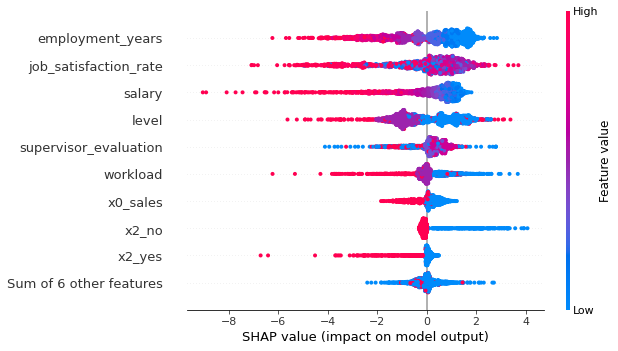

In [112]:
#shap_values = explainer(X_test_p)

#shap.plots.beeswarm(shap_values) 

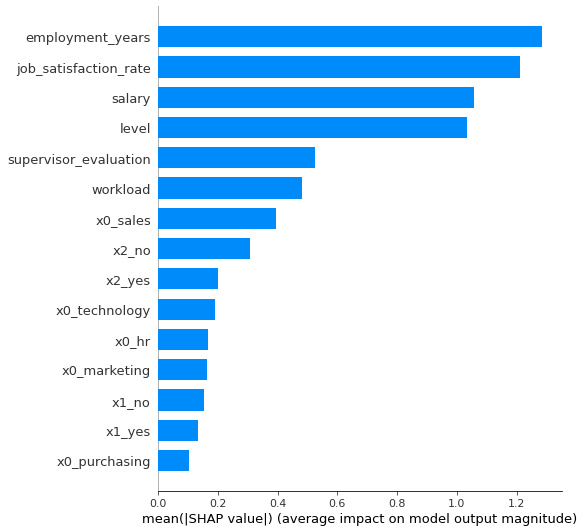

In [113]:
#shap.summary_plot(shap_values, plot_type="bar") 


Чем дольше сотрудник отработал в компании, тем меньше его вероятность уволиться.<br>
Чем выше его удовлетворенность работой и выше зарплата, тем меньше вероятность уволиться.<br>
Сотрудники уровня junior увольняются чаще.

##  Общие выводы

### Общий анализ данных:<br>
Были изучены данные, предоставленные компанией "Работа с заботой".<br>
Данные содержат характеристики сотрудников.<br>
Целью исследования было:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. 

### Предобработка данных:
В данных о характеристиках сотрудников не было обнаружено дубликатов.<br>
Было обнаружено несколько строк.<br>
Всего получилось 4000 строк в тренировочной выборке и 2000 строк в тестовой.


### Исследовательский анализ:
Проанализировали признаки:
Аномальных значений не увидели.
Необходимо масштабировать количественные признаки и закодировать категориальные для использования их в модели. А также проследить, нет ли взаимосвязи между признаками и наблюдается ли линейная взаимосвязь с целевым признаком.

### Корреляционный анализ:
Видим связь целевого признака Уровень удовлетворенности сотрудника и его оценкой начальства.<br>
Наблюдаются связи между признаками: зарплаты и должности/загрузки сотрудника; уровня сотрудника и количества отработанных лет.<br>
Мультиколлинеарности не обнаружено.

### Обучение модели:
К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder, OrdinalEncoder).<br>
Применяли модели:<br>
    - DecisionTreeRegressor с параметрами max_depth, min_samples_leaf, min_samples_split<br>
    - LinearRegression<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали собственной метрикой SMAPE («симметричное среднее абсолютное процентное отклонение»)<br>
Наилучшей оказалась модель **дерево решений** с параметрами:<br>
max_depth=18, min_samples_leaf=6, min_samples_split=11<br>
На тестовой выборке она показывает результат 13.86
 
### Загрузка данных
Загрузили новые данные с целевым признаком - увольнение сотрудника.

### Портрет уволившегося сотрудника:
- Больше всего увольняется сотрудников из отдела sales, но если посмотреть на долю уволившихся сотрудников, то больше всего она в technology: 0.3.<br>
Меньше всего увольнений в hr, доля составляет 0.25.
- Больше всего сотрудников увольняется с уровнем junior - половина сотрудников уровня junior увольняется. Доля увольняющихся middle и sinior гораздо меньше и сотсавляет 0.06/0.05 соответственно.
- Интересно, что больше всего сотрудников увольняется с уровнем загрузки low, а сильно загруженные сотрудники остаются. Доля уволившихся сотрудников по уровням low, medium, high составляет 0.43, 0.23, 0.18 соответственно.
- уровень зарплаты уволившихся и оставшихся сотрудников существенно различается: у уволившихся сотрудников средняя зарплата гораздо меньше.

### Зависимость увольнения от уровня удовлетворенности сотрудника:
Среднее значение уровня удовлетворенности у оставшихся сотрудников значительно выше, чем у уволившихся. Это видно и по распределению уровня у оставшихся сотрудников. Оно скошено вправо.

### Построение второй модели.
К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder, OrdinalEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали метрикой ROC_AUC.<br>

Наилучшей оказалась модель SVC с полиномиальным ядром, равным 4 и методом масштабирования MinMaxScaler().
Метрика roc_auc составила 0.92.

### Рекомендации для бизнеса:
Целью построения моделей является снизить финансовые убытки и уменьшить отток сотрудников.<br>
На увольнение сотрудников влияет уровень удовлетворенности работы сотрудником. Важно отслеживать данный показатель, чтобы избежать увольнений.<br>
Чем дольше сотрудник работает в компании, тем меньше его вероятность уволиться.<br>
В ходе анализа было выявлено, что уходит большое количество специалистов уровня junior. Чаще легче перейти в другую компанию для быстрого роста. В связи с этим необходимо продумать программы привлечения и мониторинг удовлетворенности сотрудниками для избежания текучки кадров.<br>
Также специалисты с низкой зарплатой чаще увольняются. Необходимо проверить систему пересмотра зарплаты.<br>
Следует учесть, что на уровень удовлетворенности влияет оценка начальства.
